In [1]:
from torch.nn import Conv2d, ReLU, AvgPool1d, Linear, LazyLinear, ReLU, Module 
from torch import hstack, exp 
import torch  
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
class CRISPRnet(Module):
    def __init__(self, nfeats = 1):
        """
        Deep learning model is a PyTorch implementation of an extended version of
        the CRISPRon model in:
        
        Xiang, Xi, et al. "Enhancing CRISPR-Cas9 gRNA efficiency prediction 
        by data integration and deep learning." Nature communications 12.1 (2021): 3238.
        
        It is generalized to allow an arbitrary number of features, 
        and dual outputs (for two parameters of response variable distribution)

        Args:
            nfeats (int, optional): Number of features. Defaults to 1.
        """
        super().__init__()
        self.C1 = Conv2d(in_channels=1, out_channels=100, kernel_size=(4,3))
        self.C2 = Conv2d(in_channels=1, out_channels=70, kernel_size=(4,5))
        self.C3 = Conv2d(in_channels=1, out_channels=40, kernel_size=(4,7))

        self.P = AvgPool1d(kernel_size=2)
        self.ReLU = ReLU()

        self.fc1 = LazyLinear(out_features=80)
        self.fc2 = Linear(80+nfeats, 80)
        self.fc3 = Linear(80, 60)  
        self.fc4 = Linear(60, 1) # for output 1 
        self.fc42 = Linear(60, 1) # for output 2
         
    def forward(self, input):
        """
        Args:
            input (Tensor, Tensor): 
        """
        
        seqs, feats = input[0], input[1]
        
        o11 = self.P(self.C1(seqs).squeeze(-2)).flatten(1,-1)
        o12 = self.P(self.C2(seqs).squeeze(-2)).flatten(1,-1)
        o13 = self.P(self.C3(seqs).squeeze(-2)).flatten(1,-1)
        
        o1 = hstack([o11,o12,o13])
        
        o2 = self.ReLU(self.fc1(o1))
        o3 = self.ReLU(self.fc2(hstack([o2, feats])))
        o4 = self.ReLU(self.fc3(o3))
        a = torch.exp(self.fc4(o4)) # added exp because parameters of beta distributions are positive 
        b = torch.exp(self.fc42(o4)) # added exp because parameters of beta distributions are positive 
        return a,b 

In [3]:
class RegressionDeepEnsemble:
    """
    Simple deep ensemble implementation that allows for both Normal, Beta,
    and Gamma distributions as the response. Note that this is the vanilla 
    implementation and not the one using predictive smoothing.  
    
    Lakshminarayanan, Balaji, Alexander Pritzel, and Charles Blundell. 
    "Simple and scalable predictive uncertainty estimation 
    using deep ensembles." Advances in neural information processing systems 30 (2017).
    
    Assumes that the output variable is a scalar. 
    """

    def __init__(self, BaseNet: torch.nn.Module, dataset, n_estimators=5,
                 batch_size=25, response_var = torch.distributions.Normal,
                 trans_func = lambda x: x):
        
        """Deep Ensembles for Univariate Regression

        Args:
            BaseNet (torch.nn.Module): Underlying neural network class for single ensemble member. 
            dataset (torch.utils.data.Dataset): Dataset used for training 
            n_estimators (int, optional): Number of models in the ensemble. Defaults to 5.
            batch_size (int, optional): Batch size used during training. Defaults to 25.
            response_var (torch.distributions.Distribution, optional): Two-parameter distribution 
                for the response variable.  
            
                Use either 
                            - torch.distributions.Normal for (-Inf, Inf) responses
                            - torch.distributions.Beta for [0,1] responses
                            - torch.distributions.Gamma for (0, Inf) responses
            
                Defaults to torch.distributions.Normal.
            
            trans_func (function, optional): Auxilliary function to transform for prediction.            
                For example, if the response variable y takes values in [0,1], we can fit a Normal-response 
                model to logit(y) and then to obtain predictions we apply inverse_logit(y).  
                
                Defaults to identity function.
        """
        
        self.ensemble = [BaseNet() for k in range(n_estimators)] 
        self.n_estimators = n_estimators
        self.loader = [DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True) for k in range(n_estimators)]
        self.response_var = response_var
        self.trans_func = trans_func 
        
    def train_ensemble(self, n_epochs=10, verbose=False):
        """Train ensemble model. 

        Args:
            n_epochs (int, optional): Number of Epochs. Defaults to 10.
            verbose (bool, optional): Print training loss update each epoch. Defaults to False.
        """
        
        for k in range(self.n_estimators): 
            print(f"Training Model {k+1}/{self.n_estimators} for {n_epochs} epochs...")
            self._train_single_net(net = self.ensemble[k], n_epochs=n_epochs, 
                                   loader=self.loader[k], verbose=verbose)
        
        print("Training Complete!")
             
    def _train_single_net(self, net, n_epochs, loader, verbose): 
        optim = torch.optim.Adam(params = net.parameters())   
        hist = []       
        for k in tqdm(range(n_epochs)): 
            hist = [] 
            for item in loader: 
                optim.zero_grad()   
                prms = [output.reshape(-1) for output in net(item[:-1])]
                loss = -self.response_var(*prms).log_prob(item[-1].reshape(-1)).mean()
                hist.append(loss.item())
                loss.backward() 
                optim.step()   
            if verbose:
                print(f"Epoch {k+1}/{n_epochs}, Train: {torch.tensor(hist).mean():.1f}")
            
        print(f"Final Epoch Training Loss: {torch.tensor(hist).mean():.3f}")
            
    def _predict(self, inputs, stochastic = True, n_samples=int(5e2)):
        """ Returns predictions for each ensemble member. Arguments same as 
        predict method.         
        """
        return [self.predict_k(inputs, k, stochastic, n_samples) 
                                   for k in range(self.n_estimators)] 
        
    def predict(self, inputs, n_samples=int(5e2)):
        """ Returns the mean prediction of all ensemble models for a given 
        input. 

        Args:
            seq: input tensor of one-hot encoded sequences
            feats: input tensor of features
            stochastic (bool, optional): If true, simulates from the predicted 
                                         response variable (needed for estimating 
                                         ensemble uncertainty). Otherwise, returns
                                         its mean. 
                                                               
            n_samples (int, optional): Number of simulated samples
                                       per *model* to use if if stochastic is True.
                                       Defaults to int(5e2).

        Returns:
            tensor: Mean prediction across all models for the inputs
        """
        with torch.no_grad(): 
            mns = torch.stack(self._predict(inputs, stochastic=False,
                                            n_samples=n_samples)).mean(axis=0)
            
        return mns 
            
    def predict_k(self, inputs, k, stochastic=True, n_samples=int(5e2)):
        """ 
        Prediction from the k-th ensemble member. Returns a 1D tensor. 
        """
        prms = [output.reshape(-1) for output in self.ensemble[k](inputs)]
        
        if not stochastic: 
            return self.trans_func(self.response_var(*prms).mean)
        else: 
            return self.trans_func(self.response_var(*prms).sample([n_samples]))
            
    def uncertainty_bounds(self, inputs, n_samples = int(5e2), lower=0.025, upper=0.975):
        """Compute the uncertainty of the response between two quantiles. 

        Args:
            inputs (tuple [Tensor]):  inputs to the ensemble (should match input signature of self.BaseNet)
            n_samples (int, optional): Number of simulated samples to estimate uncertainty quantiles. 
                                       Defaults to int(5e2). 
            lower (float, optional): Lower uncertainty quantile amount. Defaults to 0.025.
            upper (float, optional): Upper uncertainty quantile amount. Defaults to 0.975.

        Returns:
            (float, float): lower and upper bounds for uncertainty interval. 
        """
        
        v = torch.stack(self._predict(inputs,
                                      stochastic=True, n_samples=n_samples)).flatten(0,1)
        
        q = torch.quantile(v, torch.tensor([lower, upper]), dim=0)
        assert lower < upper, "lower must be less than upper!"
        return q[0,:], q[1,:]
     
    def plot_uncertainties(self, inputs, true_vals, 
                           plot_means = False, n_samples=int(5e2),
                           lower=0.025, upper=0.975): 
        """Helper function to visualise uncertainties on data with known 
           response. 

        Args:
            input: inputs to the ensemble (should match input signature of self.BaseNet)
            true_vals (Tensor): observed response values
            plot_means (bool, optional): Plot the prediction of the individual models. Defaults to False.
            n_samples (_type_, optional): Number of simulated samples from each model 
                                          to estimate uncertainty quantiles. Defaults to int(5e2).
            lower (float, optional): Lower uncertainty quantile amount. Defaults to 0.025.
            upper (float, optional): Upper uncertainty quantile amount. Defaults to 0.975.
        """
        
        mns = torch.stack(self._predict(inputs, stochastic=False, n_samples=n_samples))
        mn = mns.mean(axis=0)

        L,U = self.uncertainty_bounds(inputs, n_samples=n_samples, lower=lower, upper=upper)
        L = L.detach().numpy().reshape(-1)
        U = U.detach().numpy().reshape(-1)

        plt.clf()
        plt.plot(L,'b_', alpha=0.25,  markersize=12)
        plt.plot(U,'b_', alpha=0.25, markersize=12)
        plt.vlines(torch.arange(0,len(L)), L, U, alpha=0.25, lw=3, label = "Uncertainty")

        if plot_means: 
            for j in range(mns.shape[0]):
                plt.plot(mns[j,:].detach().numpy(), "r.", markersize=10, alpha=0.25)
                
        plt.plot(self.trans_func(true_vals).detach().numpy(), 'k*', label = "Truth", markersize=9)
        plt.plot(mn.detach().numpy(), 'b.', label = "Prediction", markersize=12)
        plt.xlabel("Test Sample")
        plt.ylabel("Efficiency")
        plt.title(f"Deep Ensemble: {self.n_estimators} Models")
        plt.legend()
        plt.show()
        

In [4]:
class Seqs_and_Features(Dataset):   
    def __init__(self, S, F, y):
        """Custom Dataset class for multimodal data involding
           both a vector-valued sequence and related static features.
        
        Args: 
            S (torch.Tensor): 3d tensor of shape [observations, embedding_length, sequence_length]
            F (torch.Tensor): 2d tensor of shape [observations,feature_length]
            y (torch.Tensor): 1d tensor of shape [observations]
        """
        
        # need to unsqueeze to add a dimension to be 
        # of the form for one channel 
        self.S = S.unsqueeze(dim=1) 
        self.F, self.y = F, y
        assert S.shape[0] == F.shape[0]
        self.n_features = F.shape[1]

    def __len__(self):
        return self.S.shape[0]

    def __getitem__(self, idx):
        return self.S[idx,:,:], self.F[idx,:], self.y[idx]

In [5]:
# Example Implementation 

dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(123)

F = torch.load("wang2019_MP_X.pt").reshape(-1,1).type(dtype)
S = torch.load("wang2019_OH_X.pt").transpose(1,2).type(dtype)

# scale response of Wang (2019) data so it is in (0,1)
y = torch.clamp((torch.load("wang2019_OH_y.pt")/100).type(dtype), 1e-3, 0.999)
     
# shuffle the dataset 
perm = torch.randperm(len(y)) 
S, F, y = S[perm, :, :], F[perm,:], y[perm]  

test_samples = 2500
myData = Seqs_and_Features(S=S[:-test_samples,:,:], F=F[:-test_samples,:], y=y[:-test_samples]) 

S_test = S[-test_samples:,:,:].unsqueeze(dim=1)  
F_test = F[-test_samples:,:]
y_test =  y[-test_samples:]

In [6]:
# Training a model is simple, you simply create a new RegressionDeepEnsemble object
# and call its `train_ensemble` method.

myEnsemble = RegressionDeepEnsemble(BaseNet=CRISPRnet, dataset=myData,
                                    n_estimators=10, batch_size=100,
                                    response_var = torch.distributions.Beta)
myEnsemble.train_ensemble(n_epochs=20)

/Users/rob/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training Model 1/10 for 20 epochs...


100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


Final Epoch Training Loss: -0.989
Training Model 2/10 for 20 epochs...


100%|██████████| 20/20 [01:29<00:00,  4.48s/it]


Final Epoch Training Loss: -0.999
Training Model 3/10 for 20 epochs...


100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


Final Epoch Training Loss: -1.021
Training Model 4/10 for 20 epochs...


100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


Final Epoch Training Loss: -1.015
Training Model 5/10 for 20 epochs...


100%|██████████| 20/20 [01:30<00:00,  4.52s/it]


Final Epoch Training Loss: -1.039
Training Model 6/10 for 20 epochs...


100%|██████████| 20/20 [01:29<00:00,  4.50s/it]


Final Epoch Training Loss: -1.021
Training Model 7/10 for 20 epochs...


100%|██████████| 20/20 [01:32<00:00,  4.61s/it]


Final Epoch Training Loss: -0.996
Training Model 8/10 for 20 epochs...


100%|██████████| 20/20 [01:31<00:00,  4.60s/it]


Final Epoch Training Loss: -1.024
Training Model 9/10 for 20 epochs...


100%|██████████| 20/20 [01:32<00:00,  4.60s/it]


Final Epoch Training Loss: -1.022
Training Model 10/10 for 20 epochs...


100%|██████████| 20/20 [01:31<00:00,  4.55s/it]

Final Epoch Training Loss: -1.030
Training Complete!


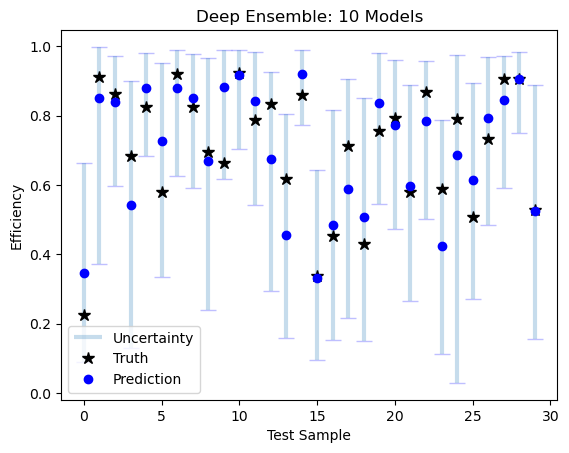

In [ ]:
# Example uncertainty plot (for top predictions)

L,U = myEnsemble.uncertainty_bounds(inputs =(S_test, F_test), n_samples=1000,
                                    lower=0.01, upper=0.99) 
pred = myEnsemble.predict(inputs = (S_test, F_test))

# below line gives sorting order for some input (e.g., prediction, true value, or uncertainty bounds)
_ids = torch.argsort(y_test, descending=True)

ids = range(30) #_ids[:100]
myEnsemble.plot_uncertainties(inputs=(S_test[ids,:,:,:], F_test[ids,:]), 
                              true_vals = y_test[ids], plot_means=False,
                              lower=0.025, upper=0.975)

Text(0, 0.5, 'Actual Efficiency')

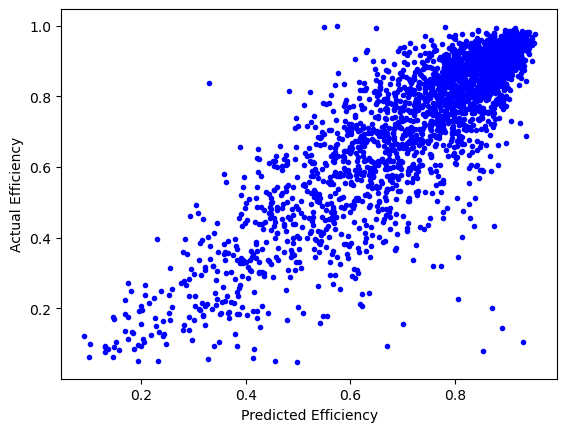

In [14]:
plt.plot(pred, y_test, 'b.')
plt.xlabel("Predicted Efficiency")
plt.ylabel("Actual Efficiency")

In [15]:
# Compute Spearman correlation between predictions and true answers in test set
from scipy.stats import spearmanr, pearsonr  
vals = (pred.numpy(), y_test)
print(f"Spearman: {round(spearmanr(*vals)[0],3)}, Pearson: {round(pearsonr(*vals)[0],3)}")

Spearman: 0.822, Pearson: 0.855
